In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import re
import pynlpir
pynlpir.open()
from sklearn import metrics

from helpers import *
from generate import *
from diagnostic import *

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

### Import model

In [89]:
model = torch.load('models/linux_3x512_0d3_gru_200l_40000E.model').cuda()
print(np.mean([test_model(model, 'data/linux/test.txt') for _ in range(10)]))

1.67400340271


### Generate text

In [ ]:
text, hiddens = generate(model, '\n\n', 500, 0.8, True, output_hiddens=True)
print(text)

### Define hypotheses

In [79]:
def hypothesis_inlinecounter(text):
    hyp = np.concatenate([np.linspace(1, -1, len(x)+1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_capswords(text):
    hyp = np.concatenate([np.full(len(x)+1, 1) if re.sub('[^a-zA-Z]+', '', x).isupper() else np.full(len(x)+1, -1) for x in text.split('\n')])[:-1]
    return hyp

def hypothesis_pos(text, pos_tag):
    hyp = text.replace('1', '0')
    for word, tag in pynlpir.segment(text):
        if tag == pos_tag:
            hyp = hyp.replace(word, '1'*len(word), 1)
        else:
            hyp = hyp.replace(word, '0'*len(word), 1)
    hyp = [1 if x=='1' else -1 for x in re.sub('[^1]', '0', hyp)]
    
    return hyp

def hypothesis_verbs(text):
    return hypothesis_pos(text, 'verb')

def hypothesis_nouns(text):
    return hypothesis_pos(text, 'noun')

In [80]:
def wrap_colored_text(text, colors, W, tabsize=4):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []
    
    # Wrap lines to width
    for char, color in zip(text, colors):
        if char == '\t':
            for i in range(tabsize):
                new_text.append(' ')
                new_colors.append(color)
        else:
            new_text.append(char)
            new_colors.append(color)
            if char == '\n':
                for i in range(W - len(new_text) % W):
                    new_text.append(' ')
                    new_colors.append(np.zeros_like(colors[0]))
                
    # Add final space to obtain (rectangular) matrix
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))
    
    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)

def plot_colored_text(text, colors, W=60, title=None, save_file=None):
    wrapped_text, wrapped_colors = wrap_colored_text(text, colors, W, tabsize=4)
    
    H = len(wrapped_text)
    plt.figure(figsize=(W/5, H/3))
    
    color_palette = sns.color_palette("RdBu_r", 255, desat=.9)
    color_palette[127] = (1.,1.,1.) # set zero to white color
    sns.heatmap(wrapped_colors, annot=wrapped_text,
                annot_kws={'color':'black',
                           'family':'monospace',
                           'horizontalalignment':'center',
                           'fontweight':'light'},
                fmt='s', cbar=False, cmap=color_palette, vmin=-2, vmax=2)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save_file:
        plt.savefig(save_file)
    plt.show()

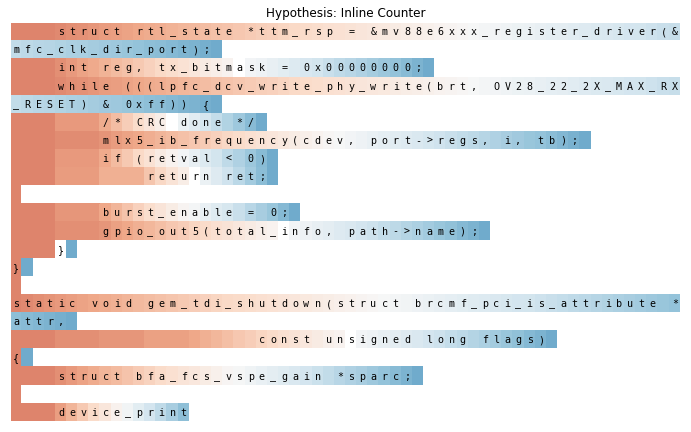

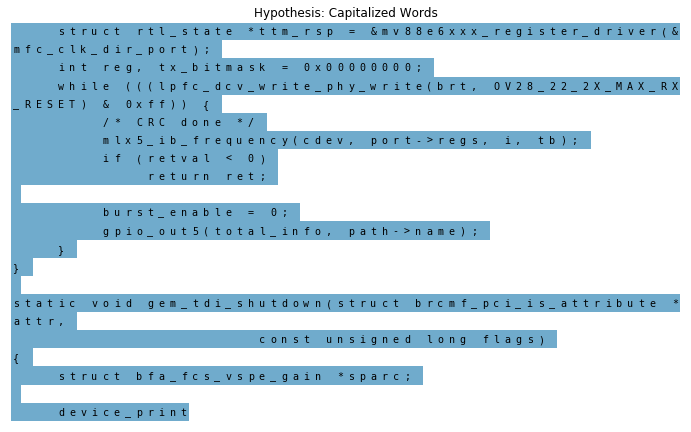

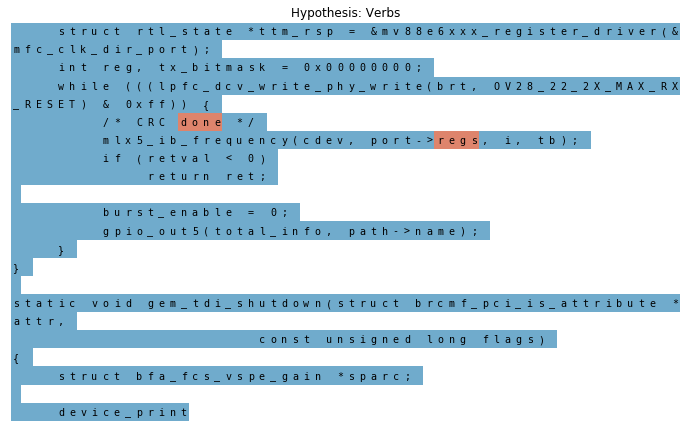

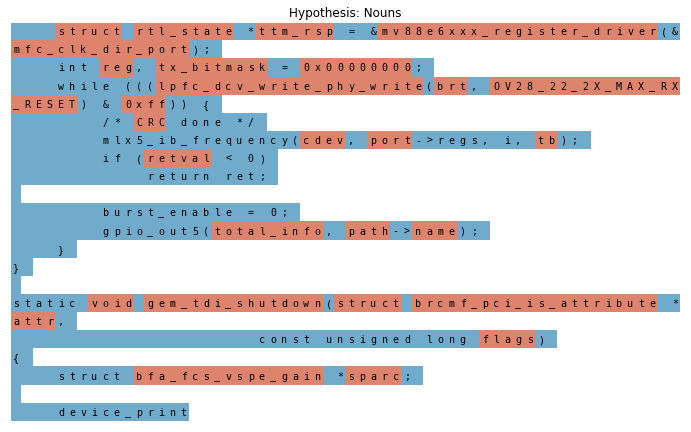

In [81]:
plot_colored_text(text, hypothesis_inlinecounter(text), title='Hypothesis: Inline Counter', save_file='plots/hyp_inlinecounter.png')
plot_colored_text(text, hypothesis_capswords(text), title='Hypothesis: Capitalized Words', save_file='plots/hyp_capswords.png')
plot_colored_text(text, hypothesis_verbs(text), title='Hypothesis: Verbs', save_file='plots/hyp_verbs')
plot_colored_text(text, hypothesis_nouns(text), title='Hypothesis: Nouns', save_file='plots/hyp_nouns')

### Hypothesis Validation using Diagnostic Classifier

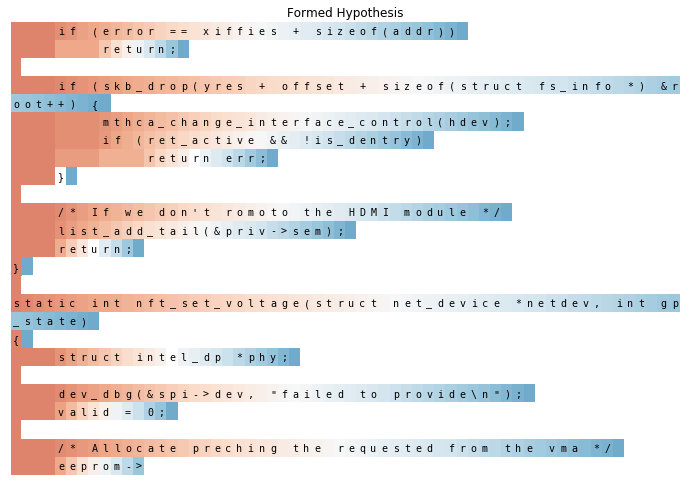

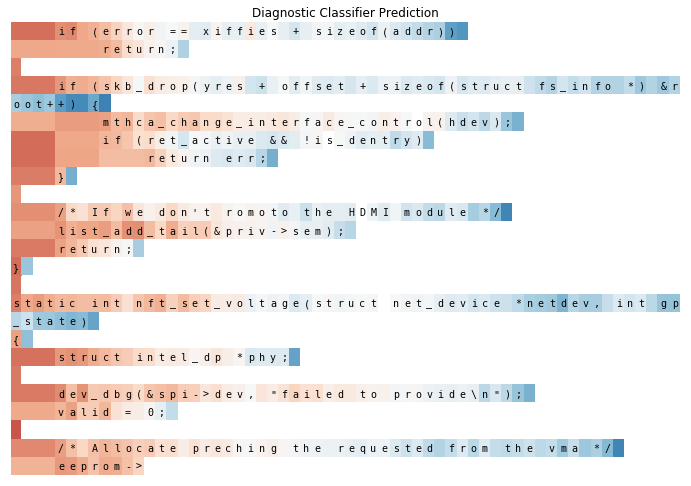

KeyboardInterrupt: 

In [87]:
y_true, y_pred = validate_hypothesis(model, LinearRegression(), hypothesis_inlinecounter)
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_capswords)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))

In [ ]:
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_nouns)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))

part of speech not recognized: 'gjtgj'


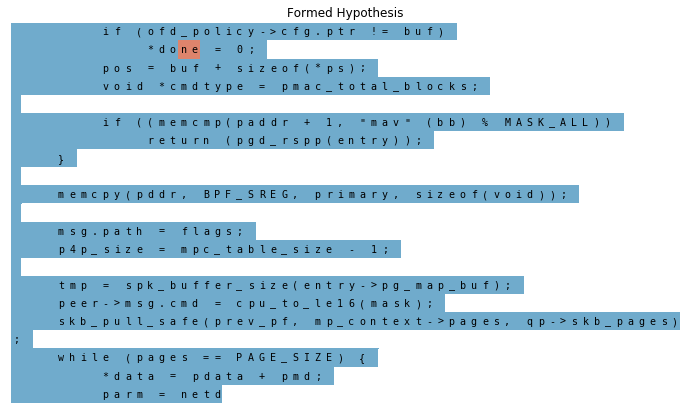

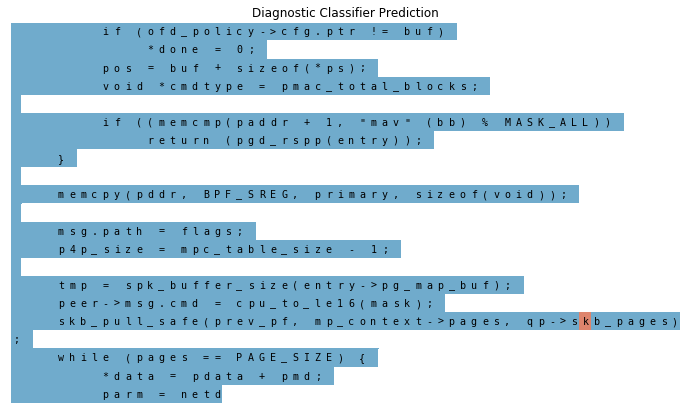

acc:       0.994
prec:      0.0
recall:    0.0
f1-score:  0.0


In [85]:
y_true, y_pred = validate_hypothesis(model, LogisticRegression(), hypothesis_verbs)
print('acc:      ', metrics.accuracy_score(y_true, y_pred))
print('prec:     ', metrics.precision_score(y_true, y_pred))
print('recall:   ', metrics.recall_score(y_true, y_pred))
print('f1-score: ', metrics.f1_score(y_true, y_pred))